In [47]:
from matplotlib import pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd
from xgcm import Grid
import dask.array as da

from scipy.signal import savgol_filter

from modes_func import *
from defPrincipalLambda import *

In [3]:
def adjust_grid(ds):
        # relevant to regular/analytical grid for now
        #
        ds = ds.reset_coords([c for c in ds.coords if 'nav' in c])
        
        # rename redundant dimensions
        _dims = (d for d in ['x_v', 'y_u', 'x_w', 'y_w'] if d in ds.dims)
        for d in _dims:
            ds = ds.rename({d: d[0]+'_rho'})
                
        # change nav variables to coordinates        
        _coords = [d for d in [d for d in ds.data_vars.keys()] if "nav_" in d]
        ds = ds.set_coords(_coords) 
        
        # rename coordinates 
        eta_suff={}
        for c in ds.coords:
            new_c = c.replace('nav_lat','eta').replace('nav_lon','xi')
            ds = ds.rename({c:new_c})
            # reset names and units
            ds[new_c] = (ds[new_c].assign_attrs(units='m', 
                                               standard_name=new_c,
                                               long_name=new_c)
                        )
        return ds
    

In [4]:
zarr_dir = '/media/durand/Gigatl/giga_2004a2014_mean/'
#V = ds.data_vars
V = ['zeta','bvf']
datasets = []
for v in V:
    ds = xr.open_zarr(zarr_dir+'%s.zarr'%(v))
    datasets.append(ds)
ds = xr.merge(datasets)
ds

<xarray.Dataset>
Dimensions:      (s_w: 51, x_rho: 1502, x_w: 1502, y_rho: 2002, y_w: 2002)
Coordinates:
    nav_lat_rho  (y_rho, x_rho) float32 dask.array<chunksize=(2002, 1502), meta=np.ndarray>
    nav_lon_rho  (y_rho, x_rho) float32 dask.array<chunksize=(2002, 1502), meta=np.ndarray>
    nav_lat_w    (y_w, x_w) float32 dask.array<chunksize=(2002, 1502), meta=np.ndarray>
    nav_lon_w    (y_w, x_w) float32 dask.array<chunksize=(2002, 1502), meta=np.ndarray>
  * s_w          (s_w) float32 -1.0 -0.98 -0.96 -0.94 ... -0.06 -0.04 -0.02 0.0
Dimensions without coordinates: x_rho, x_w, y_rho, y_w
Data variables:
    zeta         (y_rho, x_rho) float32 dask.array<chunksize=(2002, 1502), meta=np.ndarray>
    bvf          (s_w, y_w, x_w) float32 dask.array<chunksize=(51, 2002, 1502), meta=np.ndarray>

In [5]:
# On ajoute dans le dataset les paramètres de grille qui sont dans le 1ier fichier
path="/media/durand/Gigatl/data/"
gridname = path+'GIGATL6_12h_inst_2004-01-15-2004-01-19.nc'
gd = xr.open_dataset(gridname, chunks={'s_rho': 1})
ds['hc'] = gd.hc
ds['h'] = gd.h
ds['Vtransform'] = gd.Vtransform
ds['sc_r'] = gd.sc_r
ds['sc_w'] = gd.sc_w
ds['Cs_r'] = gd.Cs_r
ds['Cs_w'] = gd.Cs_w
ds['angle'] = gd.angle
ds['mask_rho'] = gd.mask_rho

In [6]:
# On modifie des dimensions et des coordonnées, on crée la grille xgcm
ds = adjust_grid(ds)
L = ds.dims['x_rho']
M = ds.dims['y_rho']
N = ds.dims['s_rho']
ds

<xarray.Dataset>
Dimensions:     (s_rho: 50, s_w: 51, x_rho: 1502, y_rho: 2002)
Coordinates:
    eta_rho     (y_rho, x_rho) float32 dask.array<chunksize=(2002, 1502), meta=np.ndarray>
    xi_rho      (y_rho, x_rho) float32 dask.array<chunksize=(2002, 1502), meta=np.ndarray>
    eta_w       (y_rho, x_rho) float32 dask.array<chunksize=(2002, 1502), meta=np.ndarray>
    xi_w        (y_rho, x_rho) float32 dask.array<chunksize=(2002, 1502), meta=np.ndarray>
  * s_w         (s_w) float32 -1.0 -0.98 -0.96 -0.94 ... -0.06 -0.04 -0.02 0.0
  * s_rho       (s_rho) float32 -0.99 -0.97 -0.95 -0.93 ... -0.05 -0.03 -0.01
Dimensions without coordinates: x_rho, y_rho
Data variables:
    zeta        (y_rho, x_rho) float32 dask.array<chunksize=(2002, 1502), meta=np.ndarray>
    bvf         (s_w, y_rho, x_rho) float32 dask.array<chunksize=(51, 2002, 1502), meta=np.ndarray>
    hc          float32 ...
    h           (y_rho, x_rho) float32 dask.array<chunksize=(2002, 1502), meta=np.ndarray>
    Vtransform  float32 ...
    sc_r        (s_rho) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    sc_w        (s_w) float32 dask.array<chunksize=(51,), meta=np.ndarray>
    Cs_r        (s_rho) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    Cs_w        (s_w) float32 dask.array<chunksize=(51,), meta=np.ndarray>
    angle       (y_rho, x_rho) float32 dask.array<chunksize=(2002, 1502), meta=np.ndarray>
    mask_rho    (y_rho, x_rho) float32 dask.array<chunksize=(2002, 1502), meta=np.ndarray>

In [7]:
# On crée la grille xgcm
ds = xgcm_grid(ds)
grid = ds.attrs['xgcm-Grid']

In [8]:
%%time
# Compute depth at rho point
z = get_z(ds,zeta=ds['zeta'],hgrid='r').compute()

/home/durand/croco/relationDispersion/definition/defPrincipal.py:166: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, these coordinates will be transposed as well unless you specify transpose_coords=False.
  z = z.transpose(*(zdim,)+_zeta.dims)


CPU times: user 3.12 s, sys: 2.04 s, total: 5.16 s
Wall time: 1.7 s


In [9]:
bvf=w2rho(ds.bvf,ds)

In [12]:
lat,lon = findLatLonIndex(ds, -23.,0.)

(795, 871)

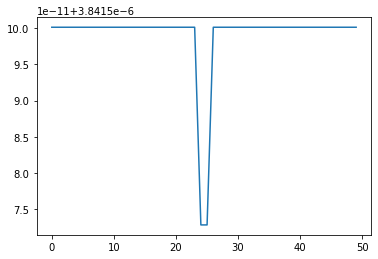

In [99]:
#plot slice latitude
latitude = 0.
vnew= slice2(ds,bvf,z, latitude=latitude)

#Find value at specific point
vnew2=vnew.isel(x_rho=lat)
vnew2
# vnew2.plot(y='z')
N=np.sqrt(vnew2)**2
N=N*0+(1.96e-3)**2
# N.plot(y='z')
N.values

In [104]:
## Compute vertical eigenmodes

phi,lmbd,zz = SL_chebsolve((N), (vnew2.z.values), Nmod="auto", Nz="auto", grav=9.80,sm=50, ksplin=3, zbot=None)

modes = phi[1]

eigval = np.real(lmbd)

for i in range(modes.shape[1]):
    modes[:,i]=norm_mode(modes[:,i],zz)

In [19]:
namevar='modes'
modeCDF = xr.Dataset({namevar:(['wmod','umod'],modes)})
modeCDF.to_netcdf('modes.nc')

In [80]:
namevar='lamba'
modeCDF = xr.Dataset({namevar:(['lambda'],eigval)})
modeCDF.to_netcdf('lambda.nc')